In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def relu(x, b=0):
    return np.clip(x-b, 0, np.inf)

def normalize(x):
    return (x -np.mean(x, axis=1, keepdims=True))/ (1e-8+np.std(x, axis=1, keepdims=True))

In [3]:
def run_dynamics(W, inputs,  dt=0.1, b=0.0):
    preacts = np.zeros([num_states, N_bar])
    acts = np.zeros([num_states, N_bar])
    for s in range(steps):
        preacts = preacts*(1-dt) + dt*(np.matmul(acts, W))+dt*inputs
        preacts = normalize(preacts)
        acts = relu(preacts, b=b)
    return normalize(preacts), acts

In [4]:
def pairwise_correlations_centered(x):
    return np.corrcoef(x-np.mean(x, 0))

In [5]:
def distance(a, b, maximum):
    dist = np.abs(a - b)
    dist = min(dist, np.abs(maximum-dist))
    return dist

In [6]:
# The model with gaussian weights and learning rate = 10.0

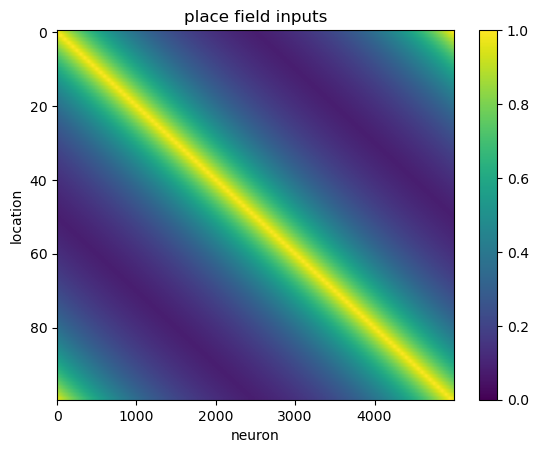

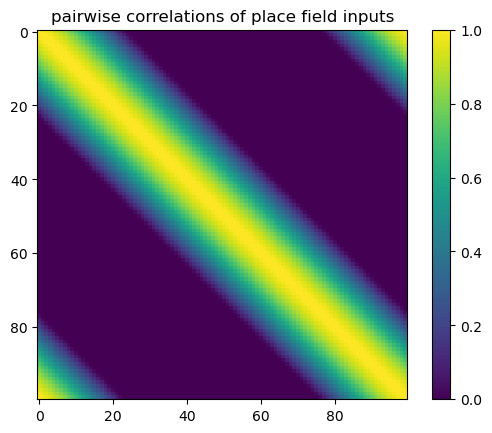

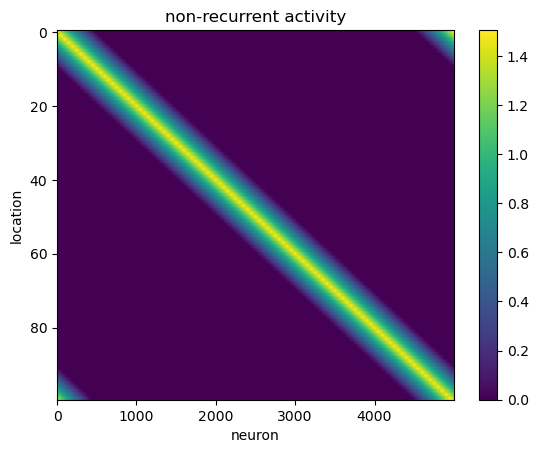

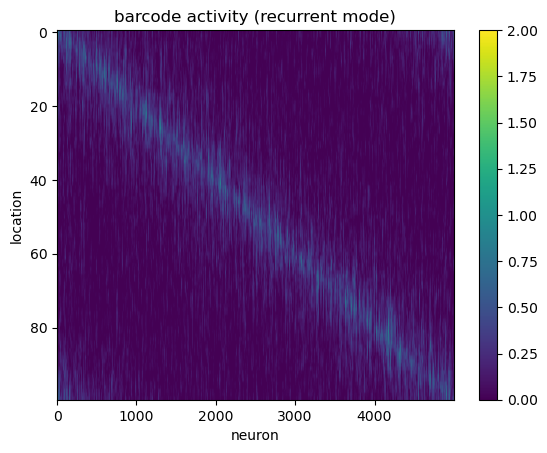

***
sparsity 0.158832


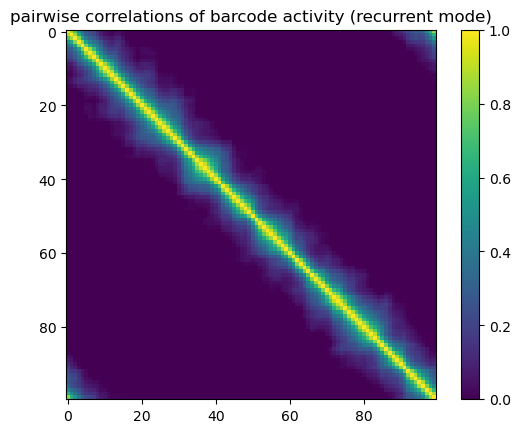

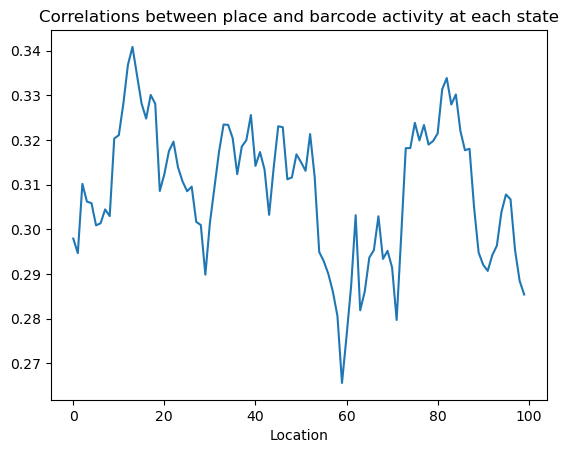

Now I just cached at location: 0


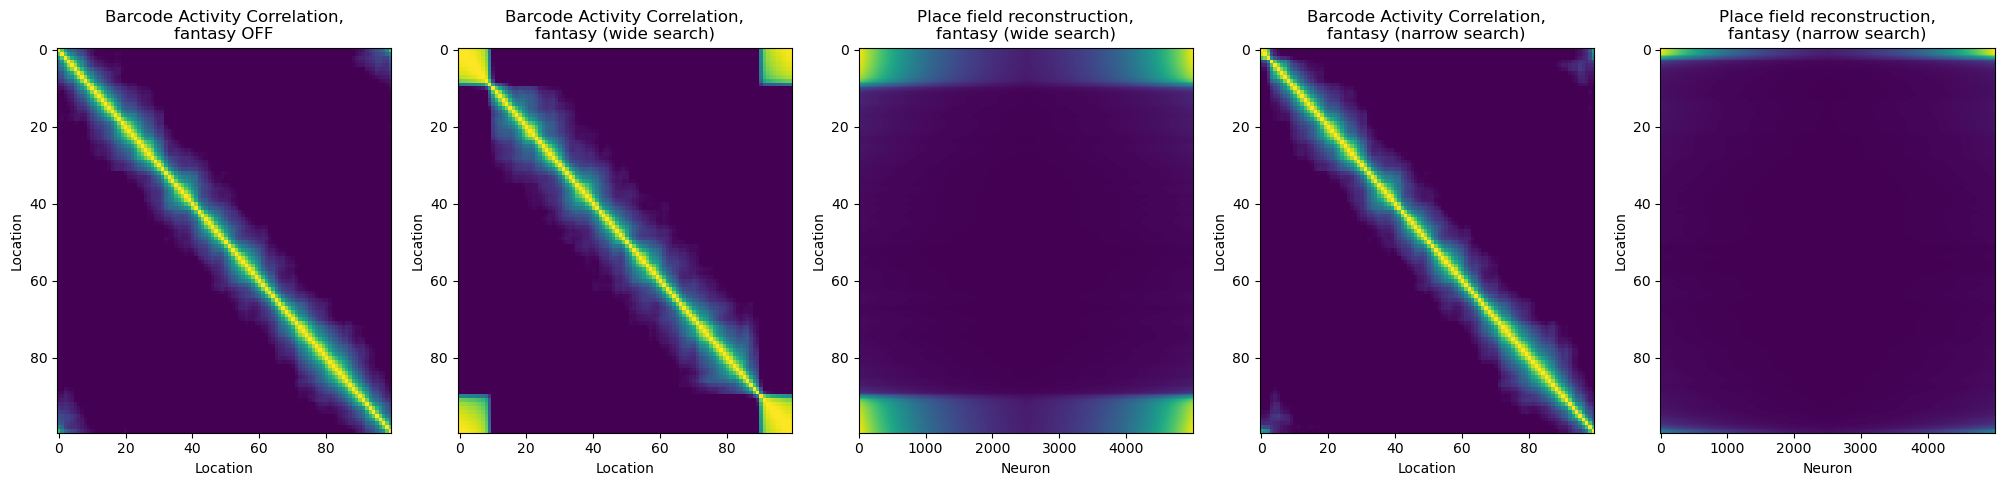

Now I just cached at location: 10


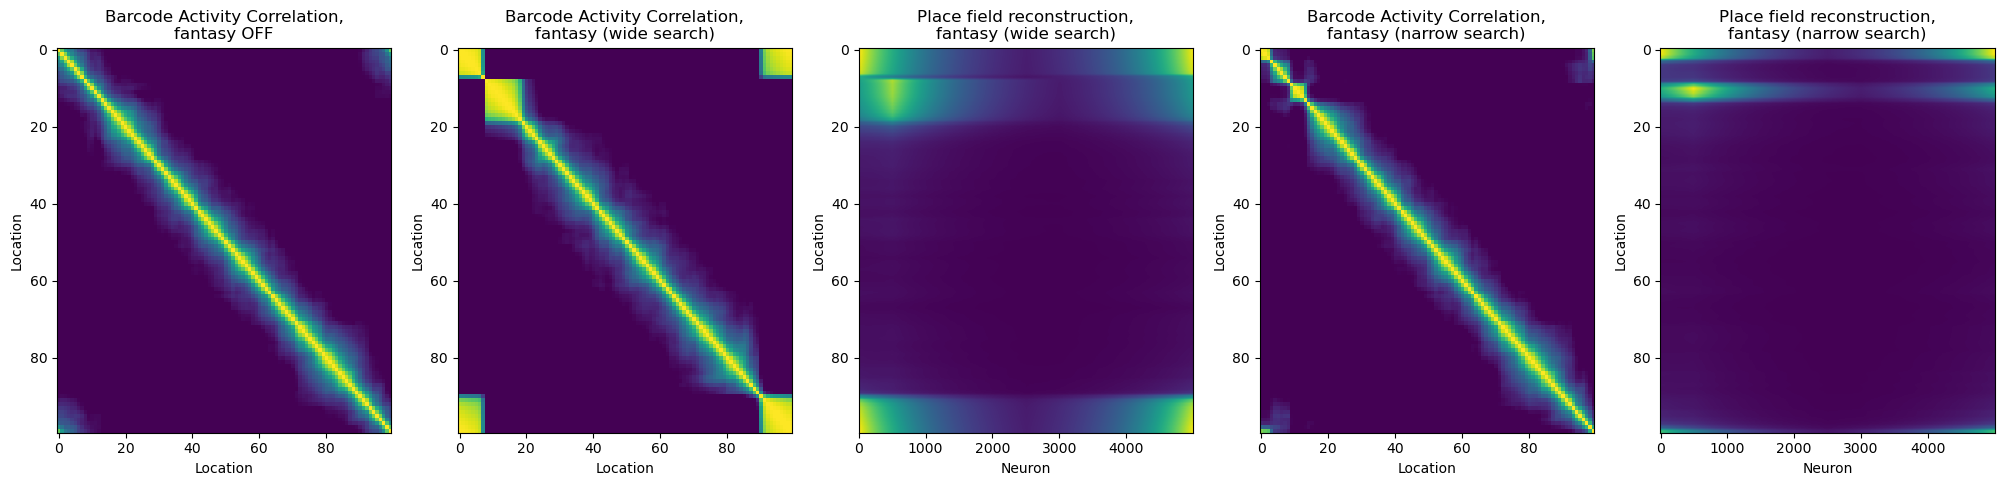

Now I just cached at location: 20


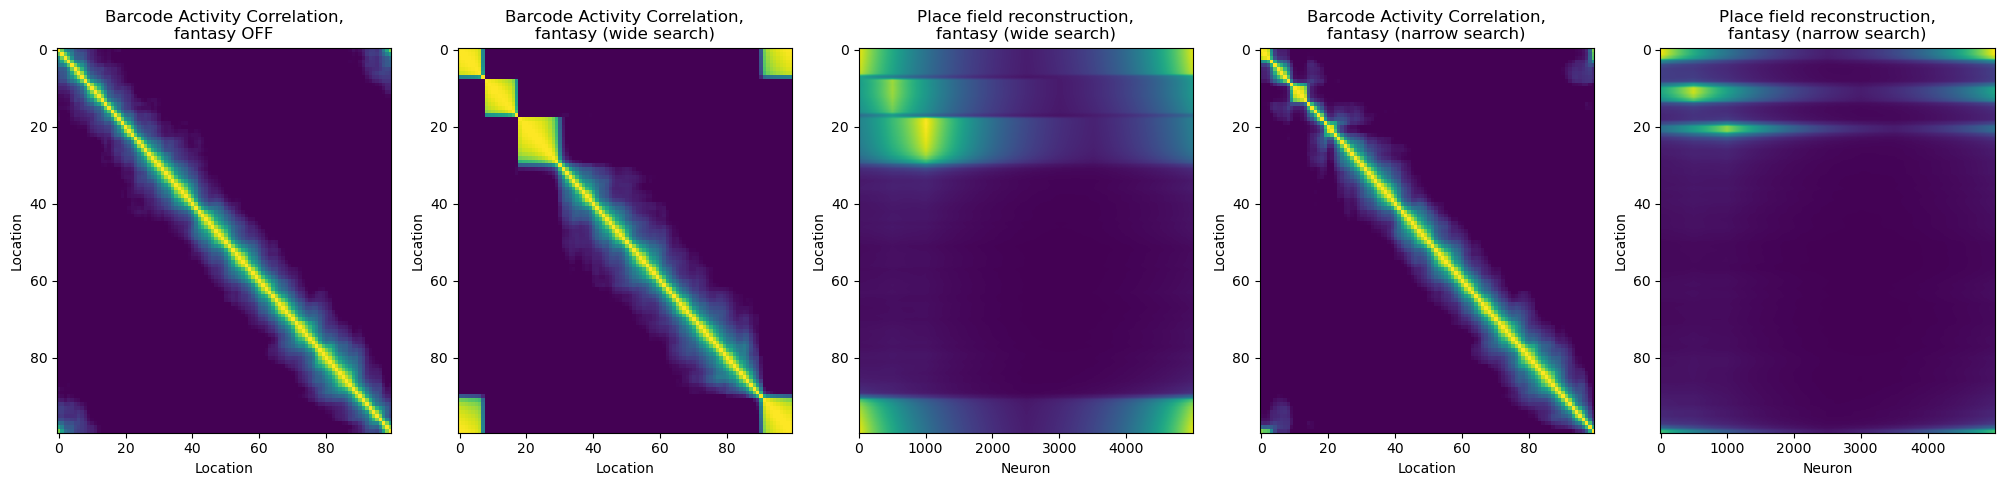

Now I just cached at location: 30


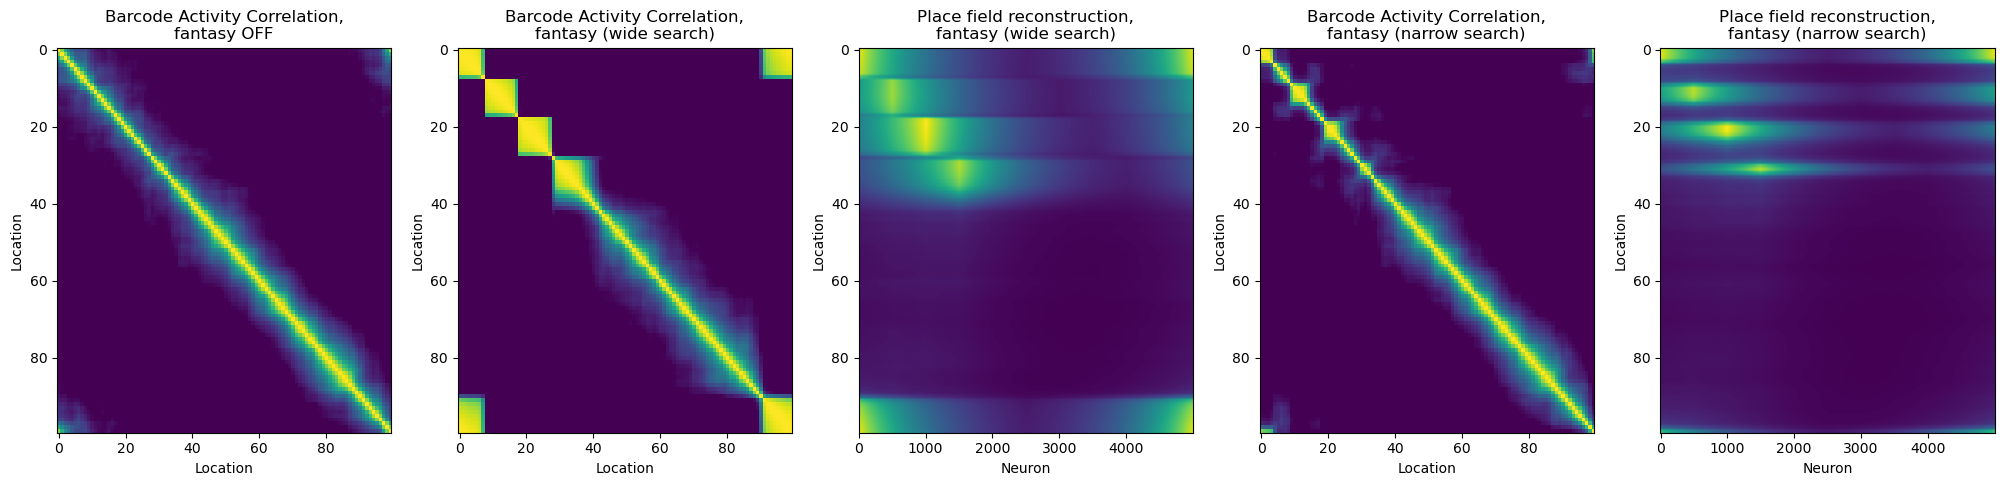

Now I just cached at location: 40


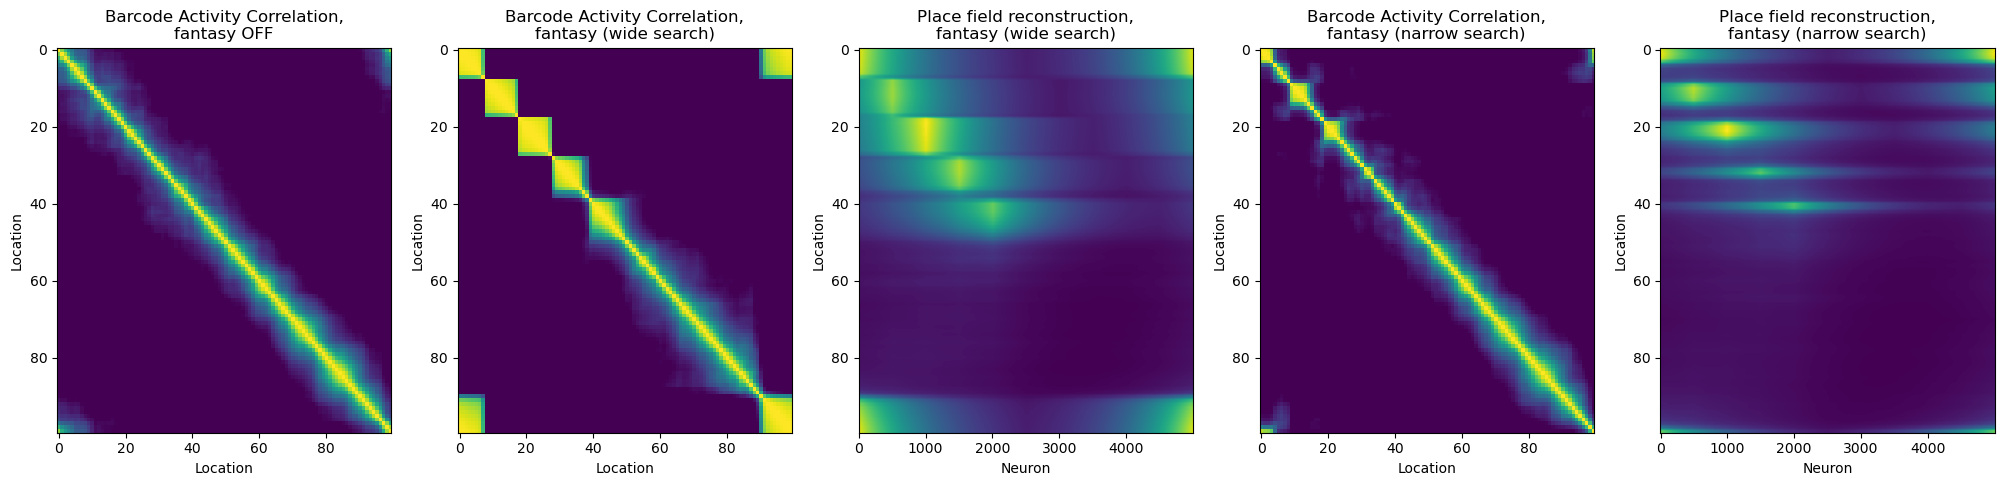

Now I just cached at location: 50


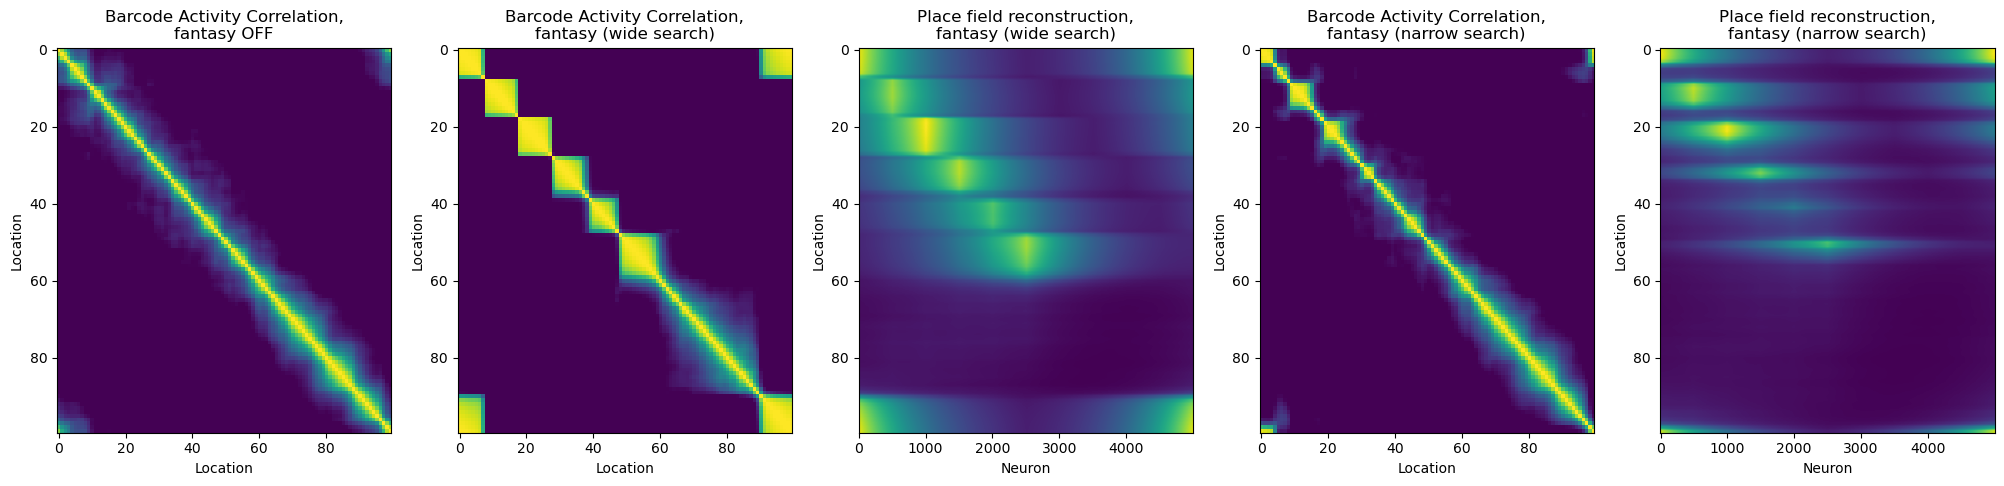

Now I just cached at location: 60


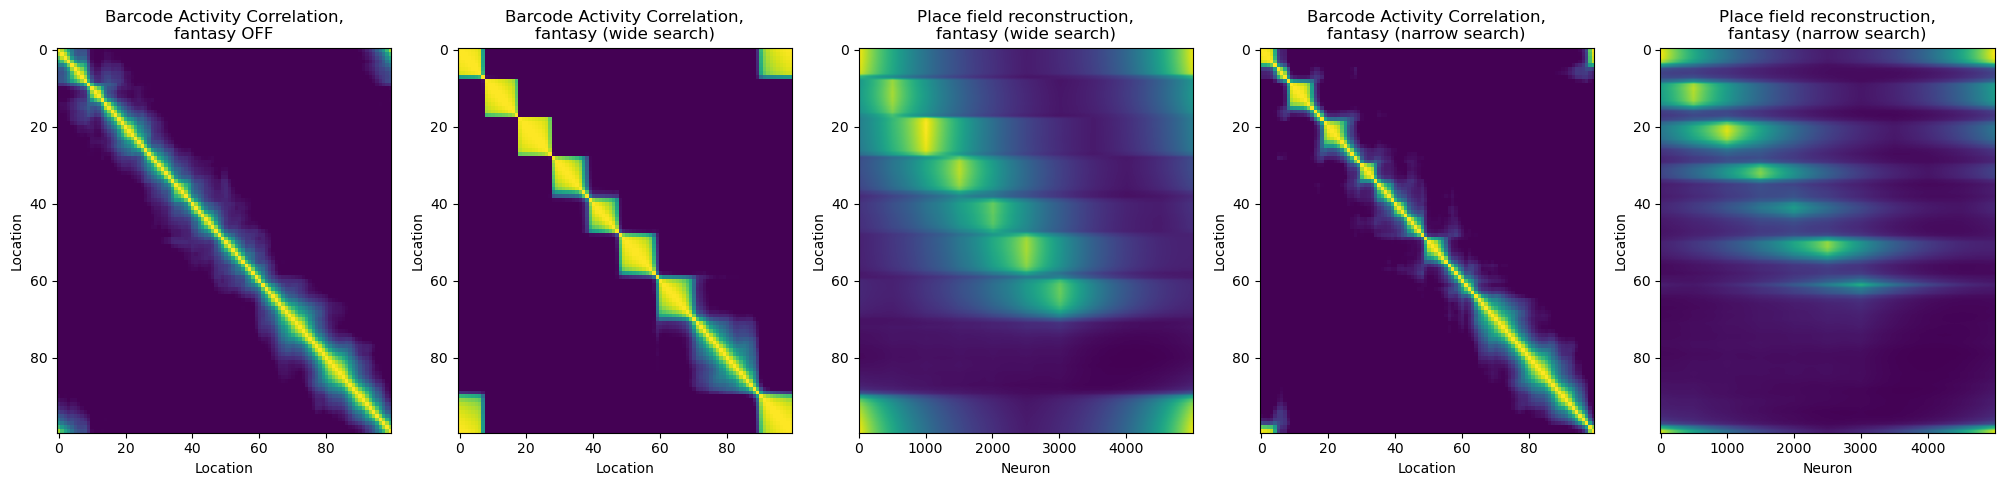

Now I just cached at location: 70


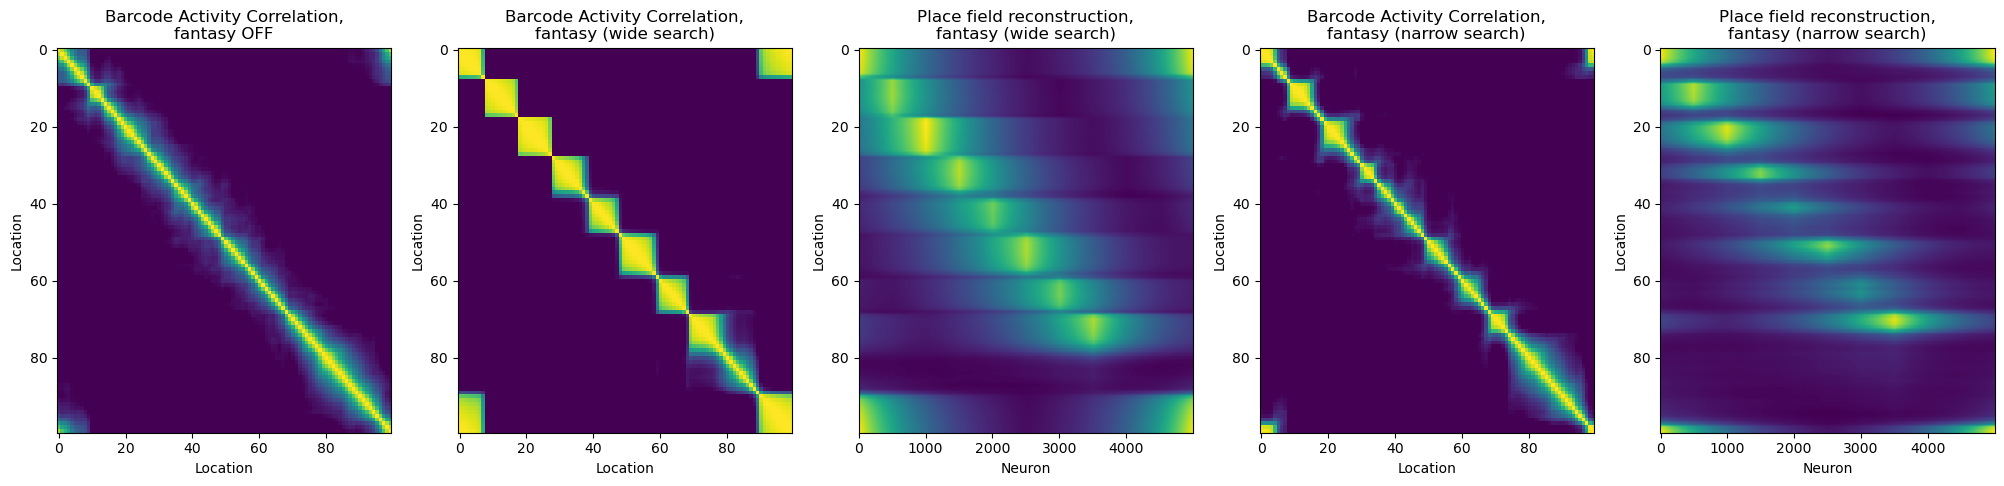

Now I just cached at location: 80


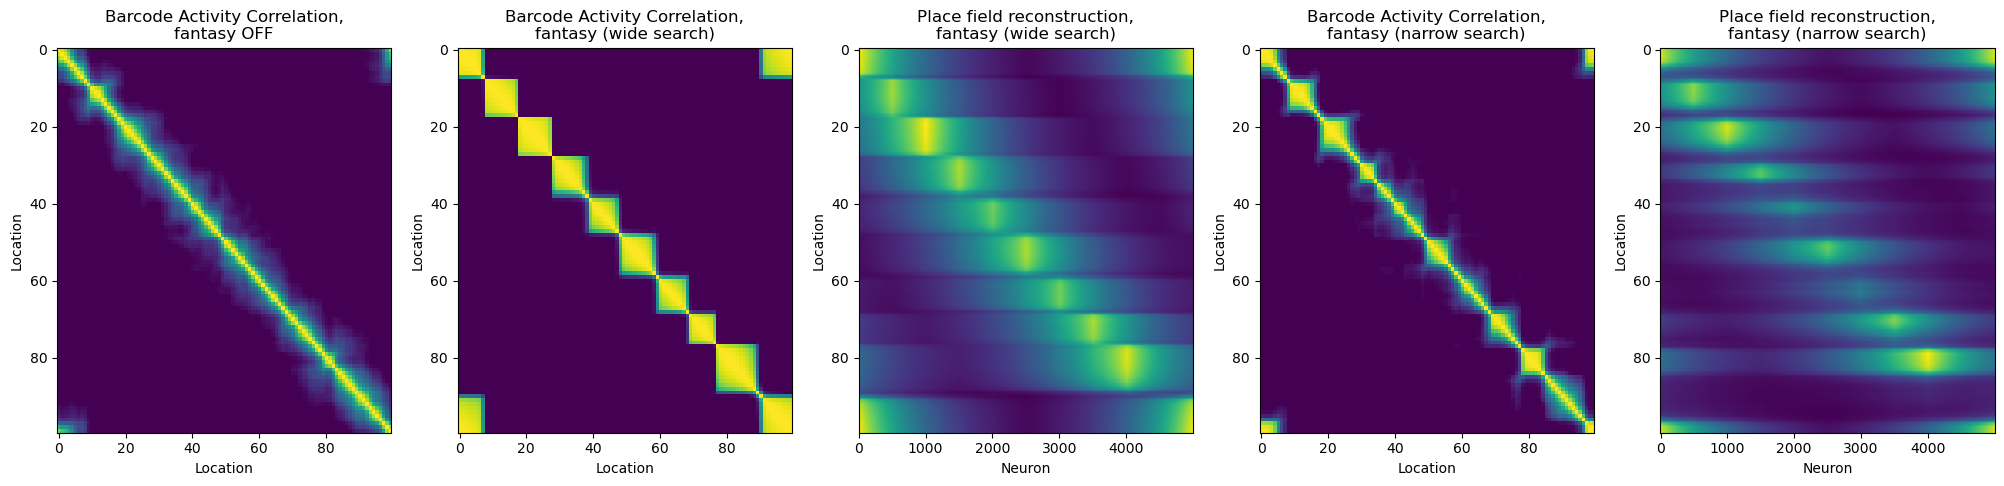

Now I just cached at location: 90


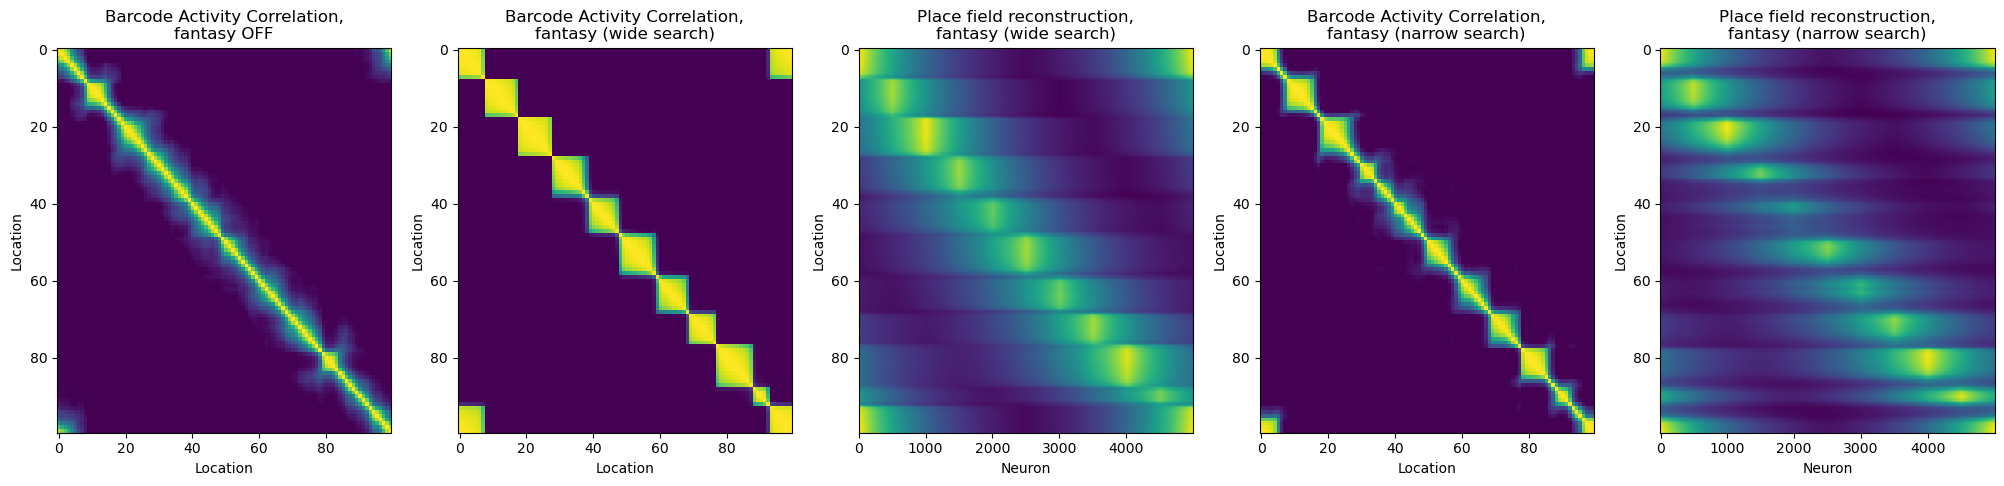

In [20]:
N_inp = 5000
N_bar = 5000

num_states = 100
decay_constant = 0.2
steps = 100
dt = 0.1
connection_sparsity = 0.01
num_connections = int(connection_sparsity*N_bar)

inputs = np.zeros([num_states, N_inp])
for s in range(num_states):
    peak = int(s / float(num_states) * N_inp)
    for n in range(N_inp):
        dist = distance(n, peak, N_inp)
        inputs[s, n] = np.exp(-(dist/(N_inp*decay_constant)))

cache_states = [n*10 for n in range(10)]
cache_acts = []

input_strength = 1.0

W_reconstruct = np.zeros([N_inp, N_bar])

# SPARSE
# W_rec = np.zeros([N_bar, N_bar])
# for n in range(N_bar):
#     W_rec[np.random.choice(N_bar, size=(num_connections,)), n] = rec_strength/np.sqrt(num_connections)\
# plasticity_bias = -0.5
# lr = 3.0

# GAUSSIAN
rec_strength = 2.0 # INITIAL PARAMETER SWEEPS
plasticity_bias = -0.6 # INITIAL PARAMETER SWEEPS
lr = 10 # INITIAL PARAMETER SWEEPS

rand_J = np.random.randn(N_bar, N_bar)
W_rec = rec_strength*(rand_J / np.sqrt(N_bar))
b=1.0
W_fantasy = np.zeros([N_bar])

plt.imshow(inputs, vmin=0,  aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("place field inputs")
plt.show()


plt.imshow(pairwise_correlations_centered(inputs), vmin=0, vmax=1)
plt.colorbar()
plt.title("pairwise correlations of place field inputs")
plt.show()

preacts, acts = run_dynamics(0*W_rec, input_strength*inputs, b=b)
nonrec_acts = acts
plt.imshow(acts, vmin=0,  aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("non-recurrent activity")
plt.show()

preacts, acts = run_dynamics(W_rec, input_strength*inputs, b=b)

plt.imshow(acts, vmin=0, vmax=2, aspect='auto')
plt.xlabel("neuron")
plt.ylabel("location")
plt.colorbar()
plt.title("barcode activity (recurrent mode)")
plt.show()

print('***')
print('sparsity', np.mean(acts>0))    
plt.imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1)
plt.colorbar()
plt.title("pairwise correlations of barcode activity (recurrent mode)")
plt.show()

acts_normalized = normalize(acts)
inputs_normalized = normalize(inputs)
corrs = [np.corrcoef(acts_normalized[i], inputs_normalized[i])[0, 1] for i in range(num_states)]
plt.title("Correlations between place and barcode activity at each state")
plt.xlabel("Location")
plt.plot(corrs)
plt.show()

narrow_search_factor = 0.05
wide_search_factor = 0.2
for cache_state in cache_states:
    
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    
    print("Now I just cached at location:", cache_state)

    preacts, acts = run_dynamics(W_rec, input_strength*inputs, b=b)
    cache_acts.append(acts)
        
    W_fantasy += acts[cache_state]
    act = acts[cache_state:cache_state+1]
    preact = preacts[cache_state:cache_state+1]
    delta_W = np.matmul(act.transpose(), act) + np.matmul(np.ones_like(act.transpose())*plasticity_bias, act)
    W_rec += lr * delta_W / N_bar
    W_reconstruct += inputs[cache_state].reshape(-1, 1) @ acts[cache_state].reshape(1, -1)
    
    preacts, acts = run_dynamics(W_rec, input_strength*inputs, b=b) 
    ax[0].set_title("Barcode Activity Correlation,\nfantasy OFF")
    ax[0].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1, aspect='auto')

    preacts, acts = run_dynamics(W_rec, input_strength*inputs+wide_search_factor*W_fantasy, b=b) 
    ax[1].set_title("Barcode Activity Correlation,\nfantasy (wide search)")
    ax[1].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1, aspect='auto')
    
    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    ax[2].set_xlabel("Neuron")
    ax[2].set_ylabel("Location")
    ax[2].imshow(reconstruct, aspect='auto')
    ax[2].set_title("Place field reconstruction,\nfantasy (wide search)")
    
    
    preacts, acts = run_dynamics(W_rec, input_strength*inputs+narrow_search_factor*W_fantasy, b=b) 
    ax[3].set_title("Barcode Activity Correlation,\nfantasy (narrow search)")
    ax[3].imshow(pairwise_correlations_centered(acts), vmin=0, vmax=1, aspect='auto')
    

    reconstruct = np.matmul(acts, W_reconstruct.transpose())
    #reconstruct = np.matmul(inputs, W_reconstruct.transpose())
    ax[4].set_xlabel("Neuron")
    ax[4].set_ylabel("Location")
    ax[4].imshow(reconstruct, aspect='auto')
    ax[4].set_title("Place field reconstruction,\nfantasy (narrow search)")
    
    for _ax in [ax[0], ax[1], ax[3]]:
        _ax.set_xlabel('Location')
        _ax.set_ylabel('Location')
        
    plt.show()

# cache-cache and cache-visit correlation

In [22]:
cache_states

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [53]:
place_noise_scale = 0.5

In [54]:
def cos_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [59]:
cache_cache_corr = {
    'Distance': [], 'Correlation': []   
}

cache_visit_corr = {
    'Distance': [], 'Correlation': []   
}

visit_visit_corr = {
    'Distance': [], 'Correlation': []   
}

sim_func = cos_sim
for i in range(len(cache_states)):
    for j in range(i, len(cache_states)):
        _distance = distance(cache_states[i], cache_states[j], num_states)
        cache_act_i = cache_acts[i][cache_states[i]]
        cache_act_j = cache_acts[j][cache_states[j]]
        
        place_noise = np.random.randn(inputs.shape[0], inputs.shape[1])*place_noise_scale
        _, place_acts = run_dynamics(0.*W_rec, input_strength*(inputs + place_noise), b=b)
        place_act_i = place_acts[cache_states[i]]
        
        place_noise = np.random.randn(inputs.shape[0], inputs.shape[1])*place_noise_scale
        _, place_acts = run_dynamics(0.*W_rec, input_strength*(inputs + place_noise), b=b)
        place_act_j = place_acts[cache_states[j]]
        
        c_c_corr = sim_func(cache_act_i, cache_act_j)
        c_v_corr = sim_func(cache_act_i, place_act_j)
        v_v_corr = sim_func(place_act_i, place_act_j)
        
        cache_cache_corr['Distance'].append(_distance)
        cache_cache_corr['Correlation'].append(c_c_corr)

        cache_visit_corr['Distance'].append(_distance)
        cache_visit_corr['Correlation'].append(c_v_corr)
        
        visit_visit_corr['Distance'].append(_distance)
        visit_visit_corr['Correlation'].append(v_v_corr)

In [60]:
import seaborn as sns

In [61]:
import pandas as pd

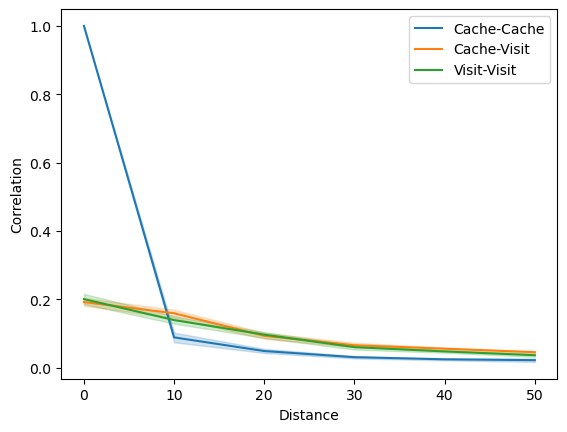

In [62]:
plt.figure()
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Cache', color='C0',
    data=pd.DataFrame(cache_cache_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Cache-Visit', color='C1',
    data=pd.DataFrame(cache_visit_corr))
sns.lineplot(
    x='Distance', y='Correlation', 
    label='Visit-Visit', color='C2',
    data=pd.DataFrame(visit_visit_corr))
plt.legend()
plt.show()

In [ ]:
\